# Dataset Generation: Positive vs Blank + Other Deposit (Unbalanced)

## Overview

This notebook constructs a training dataset by combining:

- Positive samples (`LABEL == 1`) – Porphyry copper deposits  
- Negative samples (`LABEL == 0`) – Both blank areas and other deposit locations

Unlike manually balanced datasets, this one **keeps the original class imbalance** and is designed to reflect real-world mineral exploration conditions.

**Add a portion of "other deposit" samples to the original negative sample set (mixing with blank samples), and retrain the model to see if it improves performance — especially in distinguishing porphyry copper deposits from other types of mineralization.**

---

## Purpose

This dataset serves as a **realistic training input** for machine learning models.  
It reflects the natural imbalance between porphyry copper deposits and non-mineralized or differently mineralized regions.

It can be used with:
- `class_weight='balanced'` in classifiers
- SMOTE or other oversampling strategies (only on training sets)

---

## Differences Compared to `06_generate_all_samples_unbalanced_only_merge_blank_samples.ipynb`

| Version | Included Samples | Use Case |
|---------|------------------|----------|
| `06`    | Positive + Blank only | Cleaner separation between mineralized and blank areas |
| `07`    | Positive + Blank + Other deposits | Reflects broader real-world conditions and harder classification boundaries |

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

In [3]:
# === 1. File paths ===
POSITIVE_PATH = "../../data/processed/positive_augmented_patch.csv"
NEG_BLANK_PATH = "../../data/processed/negative_blank_samples.csv"
NEG_OTHER_PATH = "../../data/processed/negative_other_deposit_samples.csv"
OUTPUT_PATH = "../../data/processed/final_samples_unbalanced_pos_vs_blank_and_other.csv"

In [9]:
# === 2. Load datasets ===
positive_df = pd.read_csv(POSITIVE_PATH)
neg_blank_df = pd.read_csv(NEG_BLANK_PATH)
neg_other_df = pd.read_csv(NEG_OTHER_PATH)

positive_df["LABEL"] = 1
neg_blank_df["LABEL"] = 0
neg_other_df["LABEL"] = 0

positive_df["SOURCE"] = "positive"
neg_blank_df["SOURCE"] = "blank_area"
neg_other_df["SOURCE"] = "other_deposit"

print(f"Loaded {len(positive_df)} positive samples")
print(f"Loaded {len(neg_blank_df)} blank samples")
print(f"Loaded {len(neg_other_df)} other deposit samples")

Loaded 950 positive samples
Loaded 3979 blank samples
Loaded 2774 other deposit samples


In [10]:
# === 3. Merge all samples ===
df_combined = pd.concat([positive_df, neg_blank_df, neg_other_df], ignore_index=True)
df_combined = df_combined.sample(frac=1.0, random_state=42).reset_index(drop=True)  # Shuffle

print(f"Combined dataset shape: {df_combined.shape}")
print(df_combined['LABEL'].value_counts())

Combined dataset shape: (7703, 10)
LABEL
0    6753
1     950
Name: count, dtype: int64


In [11]:
df_combined.head()

,source_deposit,LABEL,LONGITUDE,LATITUDE,SOURCE,PROVINCEID,OCCURRENCE_NAME,CLASS,STATE,COMMODITY_NAMES
0,NaN,0,128.335700,-16.699200,other_deposit,NaN,Matsu,mineral deposit,WA,Iron
1,NaN,0,141.150432,-19.404265,blank_area,GA.GeologicProvince.559204,NaN,NaN,NaN,NaN
2,NaN,0,150.068600,-26.447300,other_deposit,NaN,GURULMUNDI,OPERATING MINE,QLD,Bentonite
3,NaN,0,141.477714,-24.020849,blank_area,GA.GeologicProvince.467256,NaN,NaN,NaN,NaN
4,NaN,0,123.346329,-24.286364,blank_area,GA.GeologicProvince.466901,NaN,NaN,NaN,NaN


C:\Users\John\AppData\Local\Temp\ipykernel_39412\4053932577.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_combined, x="LABEL", palette="Set2")


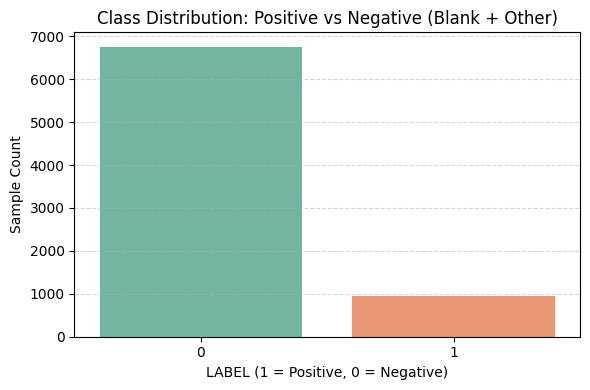

In [12]:
# === 4. Class barplot ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df_combined, x="LABEL", palette="Set2")
plt.title("Class Distribution: Positive vs Negative (Blank + Other)")
plt.xlabel("LABEL (1 = Positive, 0 = Negative)")
plt.ylabel("Sample Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

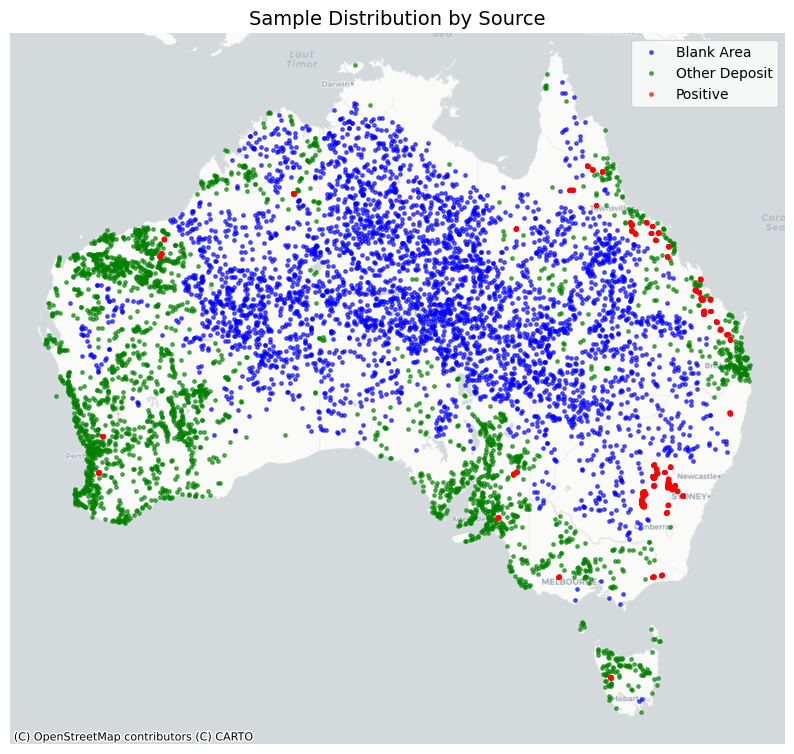

In [15]:
# === 5. Geospatial visualization ===
assert "LONGITUDE" in df_combined.columns and "LATITUDE" in df_combined.columns, "Missing coordinates"

fig, ax = plt.subplots(figsize=(10, 12))

# Plot base map using Web Mercator
gdf = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined.LONGITUDE, df_combined.LATITUDE),
    crs="EPSG:4326"
).to_crs(epsg=3857)

colors = {"blank_area": "blue", "other_deposit": "green", "positive": "red"}

for src, group in gdf.groupby("SOURCE"):
    group.plot(ax=ax, markersize=6, label=src.replace("_", " ").title(), color=colors[src], alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Sample Distribution by Source", fontsize=14)
ax.axis("off")
ax.legend()
plt.show()

In [16]:
# === 6. Save combined dataset ===
df_combined.to_csv(OUTPUT_PATH, index=False)
print(f"Merged dataset saved to: {OUTPUT_PATH}")

Merged dataset saved to: ../../data/processed/final_samples_unbalanced_pos_vs_blank_and_other.csv
